# [Video Game]
#### Data World 
    *https://data.world/craigkelly/steam-game-data
    [Shareholder] They are a publisher, they want buy a new team but want to make sure they make good choice
        [Question1] Can we build a predict/regression model to predict a potential interval for steamspyowners? 
        [Question2] Metacritic scores are from 0 -100. Could we build a classifer model?
#### Kaggle
	*https://www.kaggle.com/gregorut/videogamesales
	*https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings
	*https://www.kaggle.com/kendallgillies/video-game-sales-and-ratings
     [Shareholder] They are a publisher is looking for recommendations for what types of game to make
         [Question1] Can we pridict Global_Sales


# [Animals]
##### Kaggle 
    *https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and
    [Shareholder] ?????
    
    [Not Enough]https://www.kaggle.com/mbogernetto/brazilian-amazon-rainforest-degradation
    [Not independent]https://www.kaggle.com/se18m502/bee-hive-metrics#weight_2017.csv
    [Not independent]https://www.kaggle.com/hocop1/cat-and-dog-breeds-parameters
    [Not independent]https://www.kaggle.com/jessicali9530/honey-production
    
# [Medical]
##### Kaggle
    [Not independent]https://www.kaggle.com/de5d5fe61fcaa6ad7a66/coronavirus-dataset-update-0206

# [Vehicle]
##### Data World
    https://data.world/nhtsa/nhtsas-odi-recalls/workspace/project-summary?agentid=nhtsa&datasetid=nhtsas-odi-recalls

##### Kaggle
    https://www.kaggle.com/austinreese/craigslist-carstrucks-data
    [ShareHolder] A small start up want to build an app to help people buy better cars off craiglist. 
        [Question1] Can we classify the cars by title_status?
        [Question2] Can we predict the odometer for the car?
        [Question3] Can we classify condition
        
    *https://www.kaggle.com/mirosval/personal-cars-classifieds
    [ShareHolder] Find cars for people app
        [Question]The user get an estimate of price_eur based on car details
        
# [Misc]
##### Buzzfeed
    *https://github.com/BuzzFeedNews/2014-06-firework-injuries
    [Shareholder] We're an evil insurance company, which collection of people should we raise the price? 
    [Question]
    
    *https://www.kaggle.com/rusiano/snooker-data-19822020#players_r.csv

# Video Game Sales Model
### Goals
This project aims to answer 2 questions

* Rather the population size of a region has a relation to carbon emissions.
* Was there a significant effect on carbon emissions based on year and state

### Project Members:
* [Laurent Mundell](https://github.com/LaurentStar)
* [Joe Hart](https://github.com/joseh4)


### Table of Contents
    -Imports
    -Data Sources
    -Load Data
    -Methods/Globals/Constants
    -Explore Data Analysis
    -Explore Data Visuals
    -Data Prep
    -Hypothesis Test I
    -Hypothesis Test II


* [Video Game Sales with Ratings](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings)
* [Google Trends work around](https://www.quora.com/How-can-I-see-absolute-search-number-volume-on-Google-Trends)

# [from past self] laurent remember to uninstall pyautogui module in python from you computer.

# Imports

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Load Data

In [119]:
_  = os.path.join('data', 'Video_Games_Sales_as_at_22_Dec_2016.csv')
video_game_df = pd.read_csv(_)

In [122]:
#video_game_df[video_game_df['Critic_Score'] < 0]
video_game_df['Critic_Score'].describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: Critic_Score, dtype: float64

# Methods/Globals/Constants

In [108]:
def fillna_average_by_target_column(row, avg_dict, target_col, effected_col):
    """
    When given a row of a dataframe, this method will use the target column to fill nan values with 
    the average associated with the catagorical values in the effected column. 
    
    Parameters
    ----------
    row :  Dataframe row.
    avg_dict : A dictionary of the average of the catagorical values in the target column of the dataframe
    target_col : index of where the target column is in the dataframe
    effected_col :  index of where the effected column is in the dataframe
    
    Returns
    -------
    a dataframe row with effect column value changed if it is null
    """
    try:
        if np.isnan(row[effected_col]):      
            row[effected_col] = np.round(avg_dict[row[target_col]], 2)
    except:
        pass #row[effected_col] = "???"
        
    return row



GENRE_CRITIC_SCORE_AVG = {'Sports' : video_game_df[video_game_df['Genre'] == 'Sports']['Critic_Score'].mean(),
              'Platform': video_game_df[video_game_df['Genre'] == 'Platform']['Critic_Score'].mean(),
              'Racing': video_game_df[video_game_df['Genre'] == 'Racing']['Critic_Score'].mean(),
              'Role-Playing': video_game_df[video_game_df['Genre'] == 'Role-Playing']['Critic_Score'].mean(),
              'Puzzle': video_game_df[video_game_df['Genre'] == 'Puzzle']['Critic_Score'].mean(),
              'Misc': video_game_df[video_game_df['Genre'] == 'Misc']['Critic_Score'].mean(),
              'Shooter': video_game_df[video_game_df['Genre'] == 'Shooter']['Critic_Score'].mean(),
              'Simulation': video_game_df[video_game_df['Genre'] == 'Simulation']['Critic_Score'].mean(),
              'Action': video_game_df[video_game_df['Genre'] == 'Action']['Critic_Score'].mean(),
              'Fighting': video_game_df[video_game_df['Genre'] == 'Fighting']['Critic_Score'].mean(),
              'Adventure' : video_game_df[video_game_df['Genre'] == 'Adventure']['Critic_Score'].mean(),
              'Strategy' : video_game_df[video_game_df['Genre'] == 'Strategy']['Critic_Score'].mean(),
}

GENRE_CRITIC_COUNT_AVG = {'Sports' : video_game_df[video_game_df['Genre'] == 'Sports']['Critic_Count'].mean(),
              'Platform': video_game_df[video_game_df['Genre'] == 'Platform']['Critic_Count'].mean(),
              'Racing': video_game_df[video_game_df['Genre'] == 'Racing']['Critic_Count'].mean(),
              'Role-Playing': video_game_df[video_game_df['Genre'] == 'Role-Playing']['Critic_Count'].mean(),
              'Puzzle': video_game_df[video_game_df['Genre'] == 'Puzzle']['Critic_Count'].mean(),
              'Misc': video_game_df[video_game_df['Genre'] == 'Misc']['Critic_Count'].mean(),
              'Shooter': video_game_df[video_game_df['Genre'] == 'Shooter']['Critic_Count'].mean(),
              'Simulation': video_game_df[video_game_df['Genre'] == 'Simulation']['Critic_Count'].mean(),
              'Action': video_game_df[video_game_df['Genre'] == 'Action']['Critic_Count'].mean(),
              'Fighting': video_game_df[video_game_df['Genre'] == 'Fighting']['Critic_Count'].mean(),
              'Adventure' : video_game_df[video_game_df['Genre'] == 'Adventure']['Critic_Count'].mean(),
              'Strategy' : video_game_df[video_game_df['Genre'] == 'Strategy']['Critic_Count'].mean(),
}


# Fix user score to get the average values
video_game_df['User_Score'] = video_game_df['User_Score'].replace(to_replace = 'tbd', value = np.nan).astype(float)

GENRE_USER_SCORE_AVG = {'Sports' : video_game_df[video_game_df['Genre'] == 'Sports']['User_Score'].mean(),
              'Platform': video_game_df[video_game_df['Genre'] == 'Platform']['User_Score'].mean(),
              'Racing': video_game_df[video_game_df['Genre'] == 'Racing']['User_Score'].mean(),
              'Role-Playing': video_game_df[video_game_df['Genre'] == 'Role-Playing']['User_Score'].mean(),
              'Puzzle': video_game_df[video_game_df['Genre'] == 'Puzzle']['User_Score'].mean(),
              'Misc': video_game_df[video_game_df['Genre'] == 'Misc']['User_Score'].mean(),
              'Shooter': video_game_df[video_game_df['Genre'] == 'Shooter']['User_Score'].mean(),
              'Simulation': video_game_df[video_game_df['Genre'] == 'Simulation']['User_Score'].mean(),
              'Action': video_game_df[video_game_df['Genre'] == 'Action']['User_Score'].mean(),
              'Fighting': video_game_df[video_game_df['Genre'] == 'Fighting']['User_Score'].mean(),
              'Adventure' : video_game_df[video_game_df['Genre'] == 'Adventure']['User_Score'].mean(),
              'Strategy' : video_game_df[video_game_df['Genre'] == 'Strategy']['User_Score'].mean(),
}

GENRE_USER_COUNT_AVG = {'Sports' : video_game_df[video_game_df['Genre'] == 'Sports']['User_Count'].mean(),
              'Platform': video_game_df[video_game_df['Genre'] == 'Platform']['User_Count'].mean(),
              'Racing': video_game_df[video_game_df['Genre'] == 'Racing']['User_Count'].mean(),
              'Role-Playing': video_game_df[video_game_df['Genre'] == 'Role-Playing']['User_Count'].mean(),
              'Puzzle': video_game_df[video_game_df['Genre'] == 'Puzzle']['User_Count'].mean(),
              'Misc': video_game_df[video_game_df['Genre'] == 'Misc']['User_Count'].mean(),
              'Shooter': video_game_df[video_game_df['Genre'] == 'Shooter']['User_Count'].mean(),
              'Simulation': video_game_df[video_game_df['Genre'] == 'Simulation']['User_Count'].mean(),
              'Action': video_game_df[video_game_df['Genre'] == 'Action']['User_Count'].mean(),
              'Fighting': video_game_df[video_game_df['Genre'] == 'Fighting']['User_Count'].mean(),
              'Adventure' : video_game_df[video_game_df['Genre'] == 'Adventure']['User_Count'].mean(),
              'Strategy' : video_game_df[video_game_df['Genre'] == 'Strategy']['User_Count'].mean(),
}


STYLE = {'purple' : '\033[95m',
               'cyan' : '\033[96m',
               'darkcyan' : '\033[36m',
               'blue' : '\033[94m',
               'green' : '\033[92m',
               'yellow' : '\033[93m',
               'red' : '\033[91m',
               'bold' : '\033[1m',
               'underline' : '\033[4m',
               'end' : '\033[0m'
}


NUMERICS = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#### Get search data.... Remove this module

In [15]:
# # Get data from Google Keyword(Please remember to uninstall this module)
# import pyautogui
# import time 
# import pyperclip

In [ ]:
# print(pyautogui.size())
# pyautogui.moveRel(0, 50, duration = 1)  # Start Location
# print(pyautogui.position())
# pyautogui.moveRel(0, 500, duration = 1) # Move by relative space
# pyautogui.click(100, 100) 
# pyautogui.typewrite("hello Geeks !") 
# pyautogui.hotkey("ctrlleft", "a") 

In [ ]:
# pyautogui.moveTo(370, 600, duration = 1) # Move to + keyword
# pyautogui.click() 
# pyautogui.moveRel(0, -150, duration = 1) # Move to enter keyword
# pyautogui.click()
# pyautogui.typewrite("hello Geeks") 
# pyautogui.moveRel(-120, -80, duration = 1) # Move to add key word to plan
# pyautogui.click()
# pyautogui.moveRel(0, 50, duration = 1)
# pyautogui.click()
# pyautogui.moveRel(-60, 180, duration = 1)
# pyautogui.click()
# pyautogui.click()
# pyautogui.scroll(2000) 
# pyautogui.moveRel(500, -300, duration = 1)
# pyautogui.click()
# pyautogui.moveRel(375, 170, duration = 4)
# pyautogui.click()
# pyautogui.click()
# pyautogui.click()
# pyautogui.hotkey("ctrlleft", "c") 
# #df[row][column] = pyperclip.paste()
# pyautogui.moveRel(-300, 270, duration = 1)
# pyautogui.click()
# pyautogui.moveRel(80, -90, duration = 1) #Move back to 
# val = input("Enter your value: ") 
# pyautogui.moveRel(80, -90, duration = 1)
# print(pyautogui.position())

In [ ]:
# pyautogui.moveTo(370, 400, duration = 1)
# pyautogui.click()
# pyautogui.scroll(1000) # Po

# Exploratory Data Analysis

In [6]:
display(video_game_df.head())
display(video_game_df.info())
display(video_game_df.describe().T)
print('Shape:', video_game_df.shape)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76,51,8,322,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,68.06,23.7,7.3,23.7,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82,73,8.3,709,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80,73,8,192,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,72.65,32.49,7.62,32.49,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       16719 non-null object
Critic_Count       16719 non-null object
User_Score         16719 non-null object
User_Count         16719 non-null object
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(6), object(10)
memory usage: 2.0+ MB


None

,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16450.0,2006.487356,5.878995,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16719.0,0.263330,0.813514,0.00,0.00,0.08,0.24,41.36
EU_Sales,16719.0,0.145025,0.503283,0.00,0.00,0.02,0.11,28.96
JP_Sales,16719.0,0.077602,0.308818,0.00,0.00,0.00,0.04,10.22
Other_Sales,16719.0,0.047332,0.186710,0.00,0.00,0.01,0.03,10.57
Global_Sales,16719.0,0.533543,1.547935,0.01,0.06,0.17,0.47,82.53


Shape: (16719, 16)


In [ ]:
for name in video_game_df.columns:
    print('-'*30, STYLE['bold'], name, STYLE['end'],'-'*30)
    display(video_game_df[name].value_counts())

# Exploratory Data Visualization

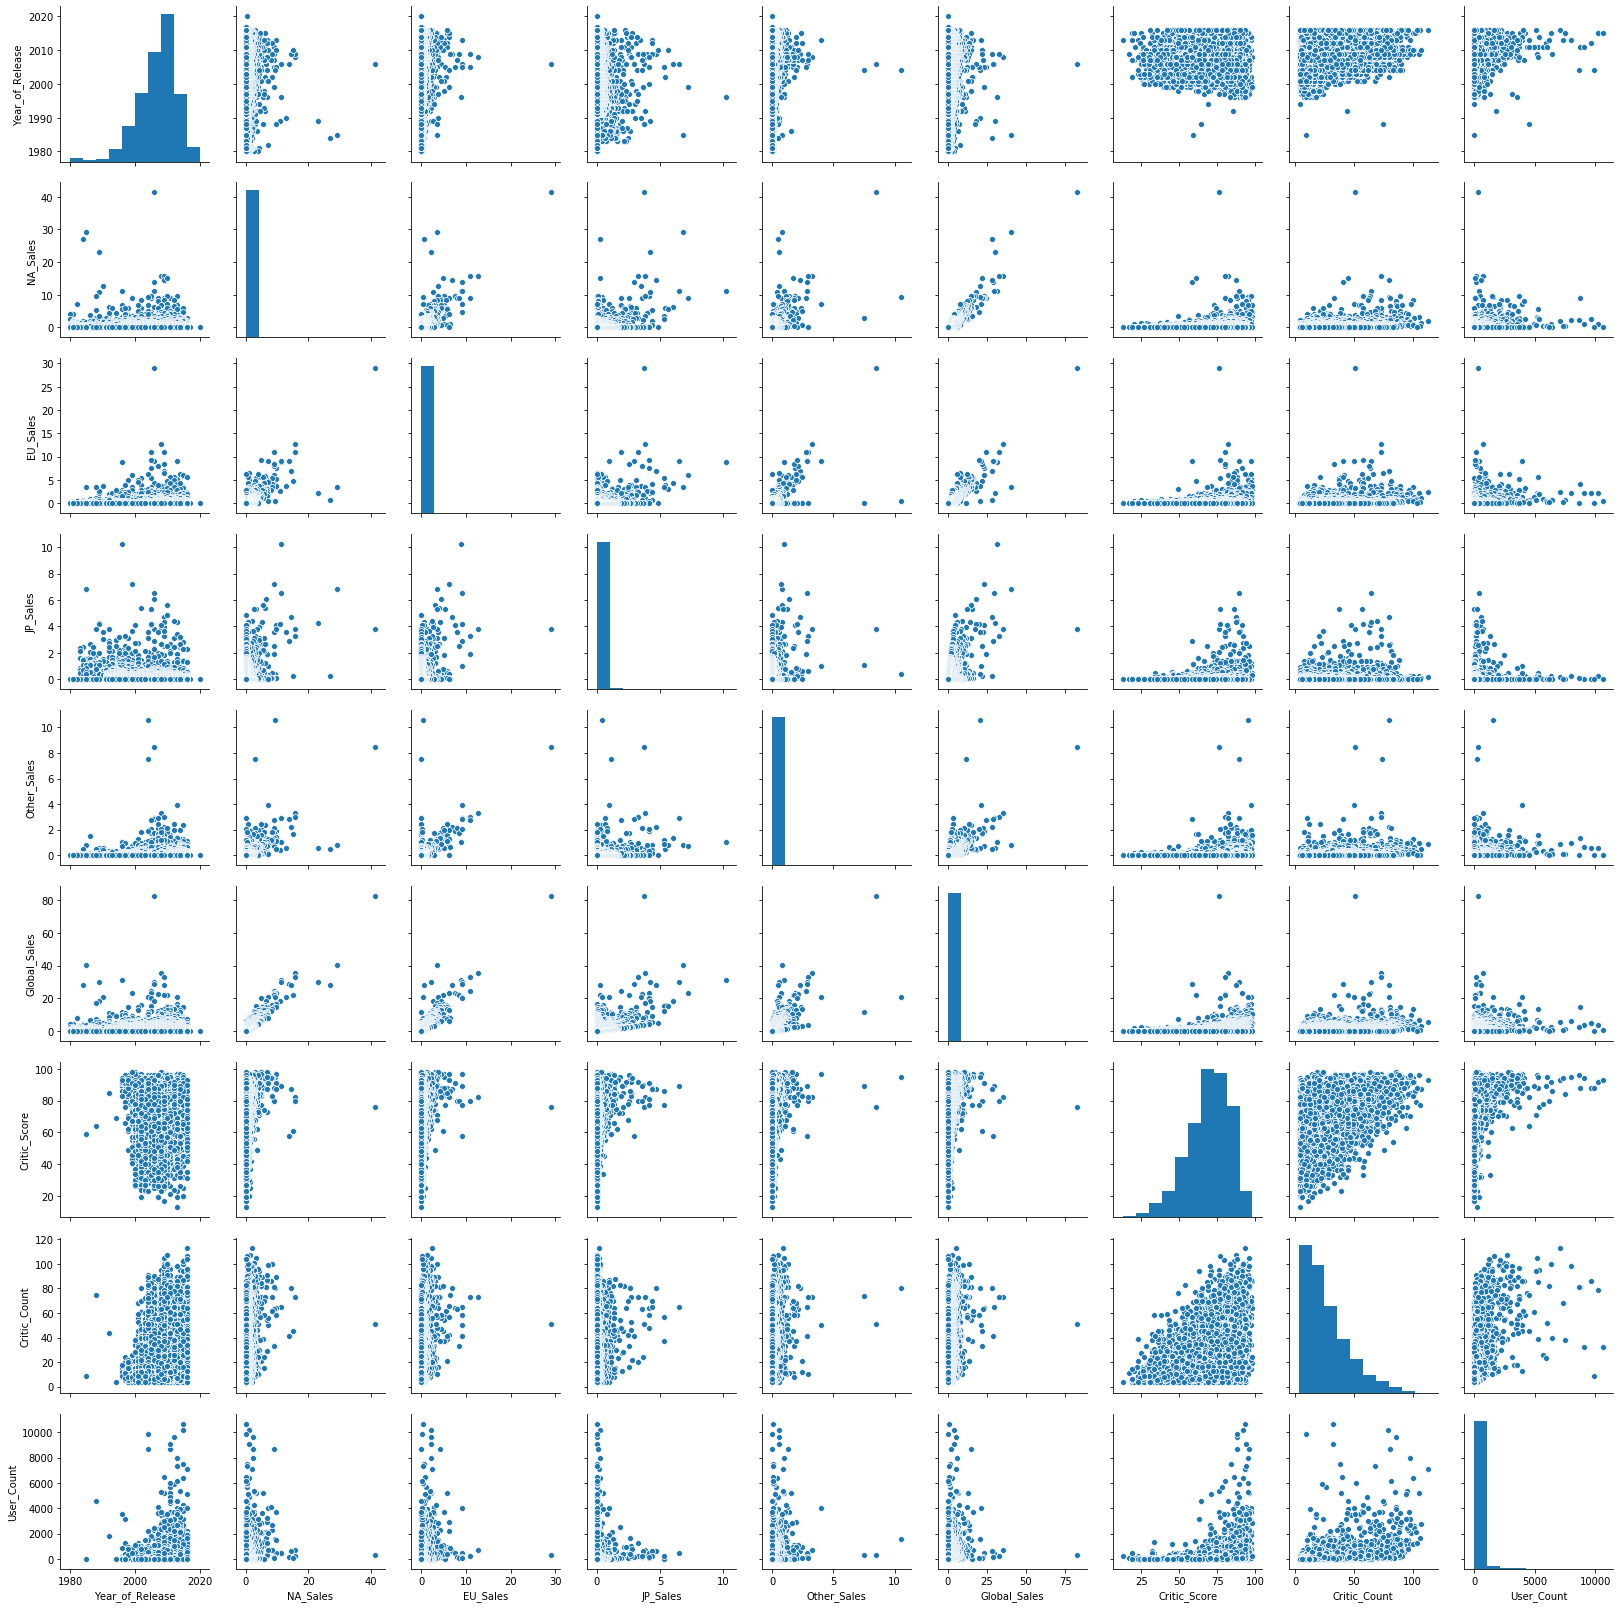

In [78]:
sns.pairplot(video_game_df);

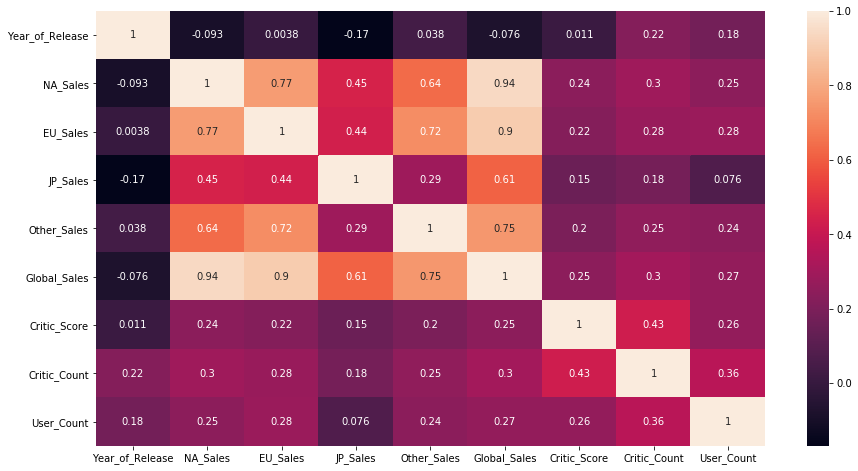

In [79]:
fig, ax = plt.subplots(figsize=(15,8))  
sns.heatmap(video_game_df.corr(), annot=True, ax=ax);

# Data Prep

In [144]:
video_game_null_fill_df = video_game_df.copy()
video_game_null_remove_df = video_game_df.copy()

In [145]:
#Drop Nan rows
video_game_null_remove_df.Genre.dropna(inplace = True)

In [146]:
#Fill all nan value with the average by genre
video_game_null_fill_df = video_game_null_fill_df.apply(lambda x : fillna_average_by_target_column(x, GENRE_CRITIC_SCORE_AVG, 3, 10),  axis=1)
video_game_null_fill_df = video_game_null_fill_df.apply(lambda x : fillna_average_by_target_column(x, GENRE_CRITIC_COUNT_AVG, 3, 11),  axis=1)
video_game_null_fill_df = video_game_null_fill_df.apply(lambda x : fillna_average_by_target_column(x, GENRE_USER_SCORE_AVG, 3, 12),  axis=1)
video_game_null_fill_df = video_game_null_fill_df.apply(lambda x : fillna_average_by_target_column(x, GENRE_CRITIC_COUNT_AVG, 3, 13),  axis=1)

#Drop all related sales columns
video_game_null_fill_df.drop(columns=['EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)

#Drop all release year Nan  rows Appoximity ~ 300 rows
#video_game_null_fill_df.dropna(subset=['Year_of_Release', 'Genre'], inplace=True)

# Make release a simple int type to represent it more accuracly 
video_game_null_fill_df['Year_of_Release'] = video_game_null_fill_df['Year_of_Release'].astype(int)

# Convert user score to float to represent accurately
video_game_null_fill_df['User_Score'] = video_game_null_fill_df['User_Score'].astype(float)

# Drop all observation below the year 1990
video_game_null_fill_df = video_game_null_fill_df[video_game_null_fill_df['Year_of_Release'] > 1995]

ValueError: Cannot convert non-finite values (NA or inf) to integer

# Cleaned Data Exploratory Analysis

In [126]:
"""
The user and critic score are on two different scales. Critics scores are 0-100, User scores are 0-10
"""

display(video_game_null_fill_df['Critic_Score'].describe())
display(video_game_null_fill_df['User_Score'].describe())

count    15743.000000
mean        68.753584
std         10.068980
min         13.000000
25%         66.000000
50%         68.060000
75%         72.650000
max         98.000000
Name: Critic_Score, dtype: float64

count    15743.000000
mean         7.113296
std          1.042476
min          0.000000
25%          6.960000
50%          7.130000
75%          7.620000
max          9.700000
Name: User_Score, dtype: float64

# Cleaned Data Exploratory Visual

Dataframe with filled nan values


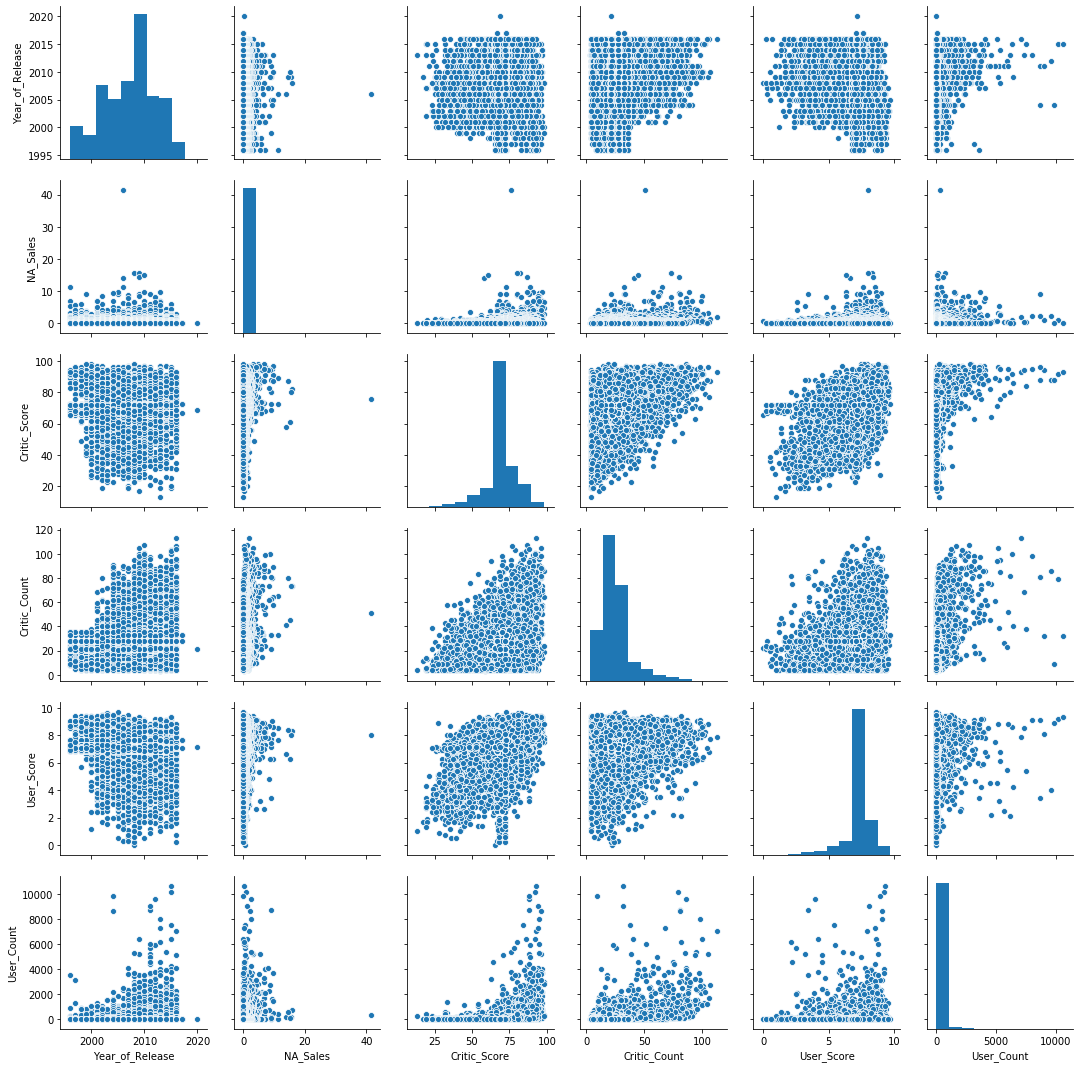

In [103]:
"""
By the year 2000 there was no signicant online present for metacritic. Below games released before 1995 were removed.
"""
print('Dataframe with filled nan values')
sns.pairplot(video_game_null_fill_df);

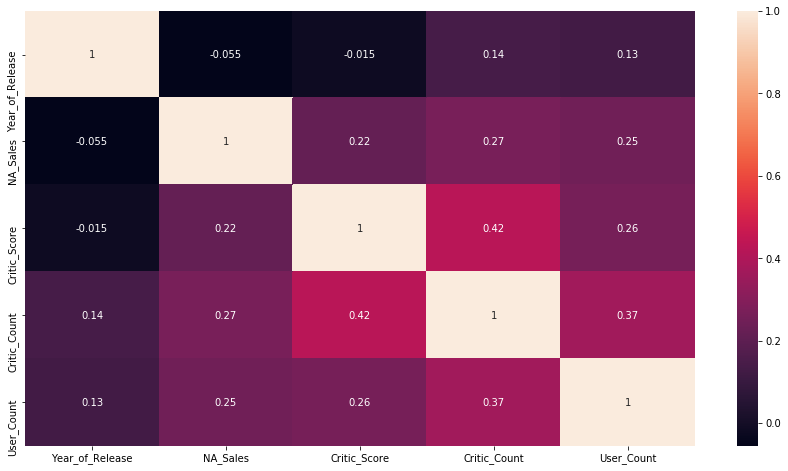

In [89]:
"""
Critic score and count are strongly correlated suggesting the number of critque averages out the game's score
"""
fig, ax = plt.subplots(figsize=(15,8))  
sns.heatmap(video_game_null_fill_df.corr(), annot=True, ax=ax);

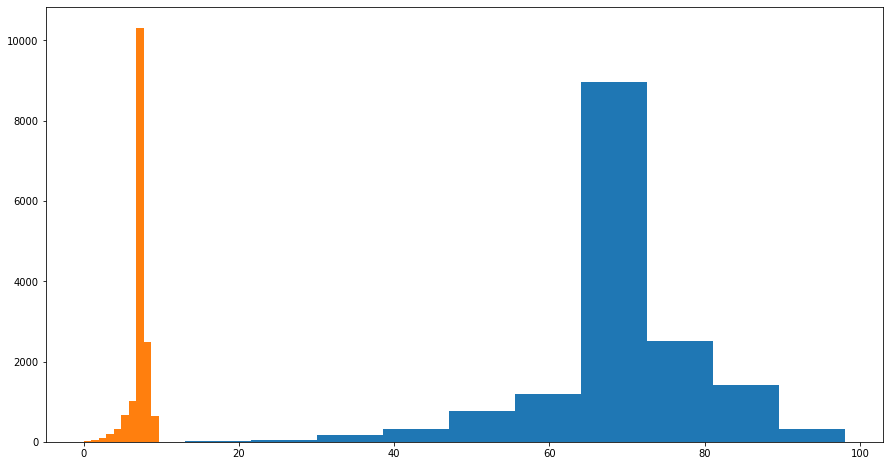

In [117]:
"""
The User scores and critic score are on different scales being 0-10 and 0-100 respectfully. 
Dispite this the distrubtions do look normal so critics and users may review the same way
"""
fig, ax = plt.subplots(figsize=(15,8))  

ax.hist(video_game_null_fill_df['Critic_Score'])
ax.hist(video_game_null_fill_df['User_Score']);

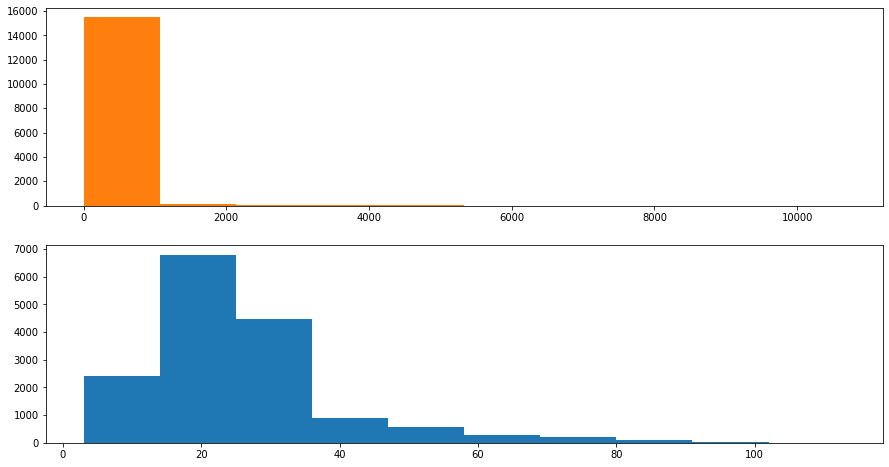

In [137]:
"""
The critics total of reviews per game is so small compared to count of user reviews,
the critics histogram doesn't appear at all. One thing about them is their skewness to the left. 
Both have the same form of skewness where for a particular game there are way more than normal
"""

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8))  

ax[0].hist(video_game_null_fill_df['Critic_Count'])
ax[0].hist(video_game_null_fill_df['User_Count'])

ax[1].hist(video_game_null_fill_df['Critic_Count']);;

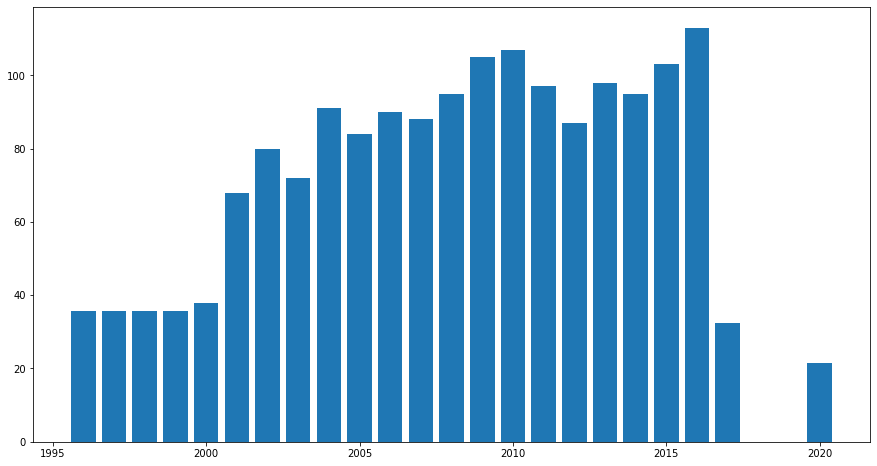

In [143]:
"""
Oh no..... What 
"""

fig, ax = plt.subplots(figsize=(15,8))  

ax.bar(x = video_game_null_fill_df['Year_of_Release'], height = video_game_null_fill_df['Critic_Count']);

In [147]:
video_game_null_fill_df[video_game_null_fill_df['Year_of_Release'] == 2020]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
5936,Imagine: Makeup Artist,DS,2020.0,Simulation,Ubisoft,0.27,68.62,21.45,tbd,21.45,Ubisoft,E


# Encoding

In [161]:
_ = pd.get_dummies(video_game_null_fill_df[['Platform']], drop_first=True)
list(pd.concat([video_game_null_fill_df, _], axis=1, sort=False).columns)[12:].sort()

In [156]:
print(video_game_null_fill_df['Platform'].unique())
print(video_game_null_fill_df['Platform'].shape)

['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
(16719,)


# Scaling/Normalizing Data

In [ ]:
video_game_df[feat].map(lambda x: np.log(x))

In [125]:
# Min-Max scaling User score and Critic score for interpretation

_ = video_game_null_fill_df['Critic_Score']
video_game_null_fill_df['Critic_Score'] = (_-min(_))/(max(_)-min(_))
video_game_null_fill_df['User_Score'] = (logcrim-min(logcrim))/(max(logcrim)-min(logcrim))
boston_features['DIS'] = (logdis-min(logdis))/(max(logdis)-min(logdis))



data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
>>> scaler = MinMaxScaler()
>>> print(scaler.fit(data))
MinMaxScaler()
>>> print(scaler.data_max_)
[ 1. 18.]
>>> print(scaler.transform(data))
[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]
>>> print(scaler.transform([[2, 2]]))
[[1.5 0. ]]

count    15743.000000
mean        68.753584
std         10.068980
min         13.000000
25%         66.000000
50%         68.060000
75%         72.650000
max         98.000000
Name: Critic_Score, dtype: float64

count    15743.000000
mean         7.113296
std          1.042476
min          0.000000
25%          6.960000
50%          7.130000
75%          7.620000
max          9.700000
Name: User_Score, dtype: float64